In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from gensim.models import Word2Vec
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
import pyarrow.parquet as pq
table= pq.read_table('/content/df_final.parquet')
df = table.to_pandas()

In [ ]:
df.head()

,prdtypecode,product_class,merged_text,merged_imageid
0,10,livres_adulte,Olivia: Personalisiertes Notizbuch / 150 Seite...,image_1263597046_product_3804725264.jpg
1,2280,magazines,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,image_1008141237_product_436067568.jpg
2,50,accessoires_jeux_videos,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,image_938777978_product_201115110.jpg
3,1280,jouets_enfance,Peluche Donald - Europe - Disneyland 2000 (Mar...,image_457047496_product_50418756.jpg
4,2705,livres_et_illustres,La Guerre Des Tuques Luc a des id&eacute;es de...,image_1077757786_product_278535884.jpg


In [ ]:
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('floresta')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package floresta to /root/nltk_data...
[nltk_data]   Unzipping corpora/floresta.zip.


True

In [ ]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

sw = set(stopwords.words(['english', 'french']))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def processing_text(row):

    soup = BeautifulSoup(row, 'html.parser')   # Remove HTML tags using BeautifulSoup
    cleaned_text = soup.get_text()


    cleaned_text = re.sub(r"[^a-zA-ZÀ-ÿàâçéèêëîïôûùüÿœ\s]", "", cleaned_text)  # Remove special characters and non-alphanumeric characters


    tokens = word_tokenize(cleaned_text) # Tokenize the cleaned text


    stop_words_removed = [word for word in tokens if word.lower() not in sw and len(word) > 2] # Remove stopwords and filter words that 2 letters or less.

    # Lemmatize and convert to lowercase
    filtered_text = [lemmatizer.lemmatize(word).lower() for word in stop_words_removed]
     # return filtered_text
    return ' '.join(filtered_text)



In [ ]:
df.shape

(84916, 4)

In [ ]:
X = df.merged_text
y = df.product_class

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the label encoder on your target labels and transform them
y_le = label_encoder.fit_transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_le, test_size=0.2, random_state=1234)

In [ ]:
X_train = X_train.apply(processing_text)
X_test = X_test.apply(processing_text)

<ipython-input-5-f5d99f5e691c>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(row, 'html.parser')   # Remove HTML tags using BeautifulSoup


In [ ]:
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

In [ ]:
# Vectorize the text data
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [ ]:
X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

In [ ]:
# Train a classification model
clf = LogisticRegression()
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Evaluate the model
y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label='positive'))
print('Recall:', recall_score(y_test, y_pred, pos_label='positive'))
print('F1 score:', f1_score(y_test, y_pred, pos_label='positive'))

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# Train and evaluate SVM model
svm_model = SVC(kernel='linear', C=1, class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', kernel='linear')

In [ ]:
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)

In [ ]:
print(svm_accuracy)

0.6913565708902496


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
y_test_original = label_encoder.inverse_transform(y_test)
svm_predictions_original = label_encoder.inverse_transform(svm_predictions)

# Generate the classification report with class names
class_report = classification_report(y_test_original, svm_predictions_original)

# Print the classification report
print(class_report)

                                  precision    recall  f1-score   support

           accessoires_interieur       0.82      0.92      0.87       832
         accessoires_jeux_videos       0.61      0.73      0.66       319
                  cartes_a_jouer       0.84      0.74      0.79       793
            decoration_interieur       0.72      0.70      0.71       970
              figurines_wargames       0.21      0.48      0.29       144
                    goodies_geek       0.63      0.68      0.66       545
                jardin_bricolage       0.51      0.69      0.59       468
          jeux_et_consoles_retro       0.80      0.88      0.84       179
                       jeux_geek       0.70      0.70      0.70       301
                    jeux_societe       0.39      0.47      0.42       408
      jeux_videos_dematerialises       0.74      0.93      0.82       146
              jeux_videos_import       0.58      0.45      0.51       503
                  jouets_enfance     

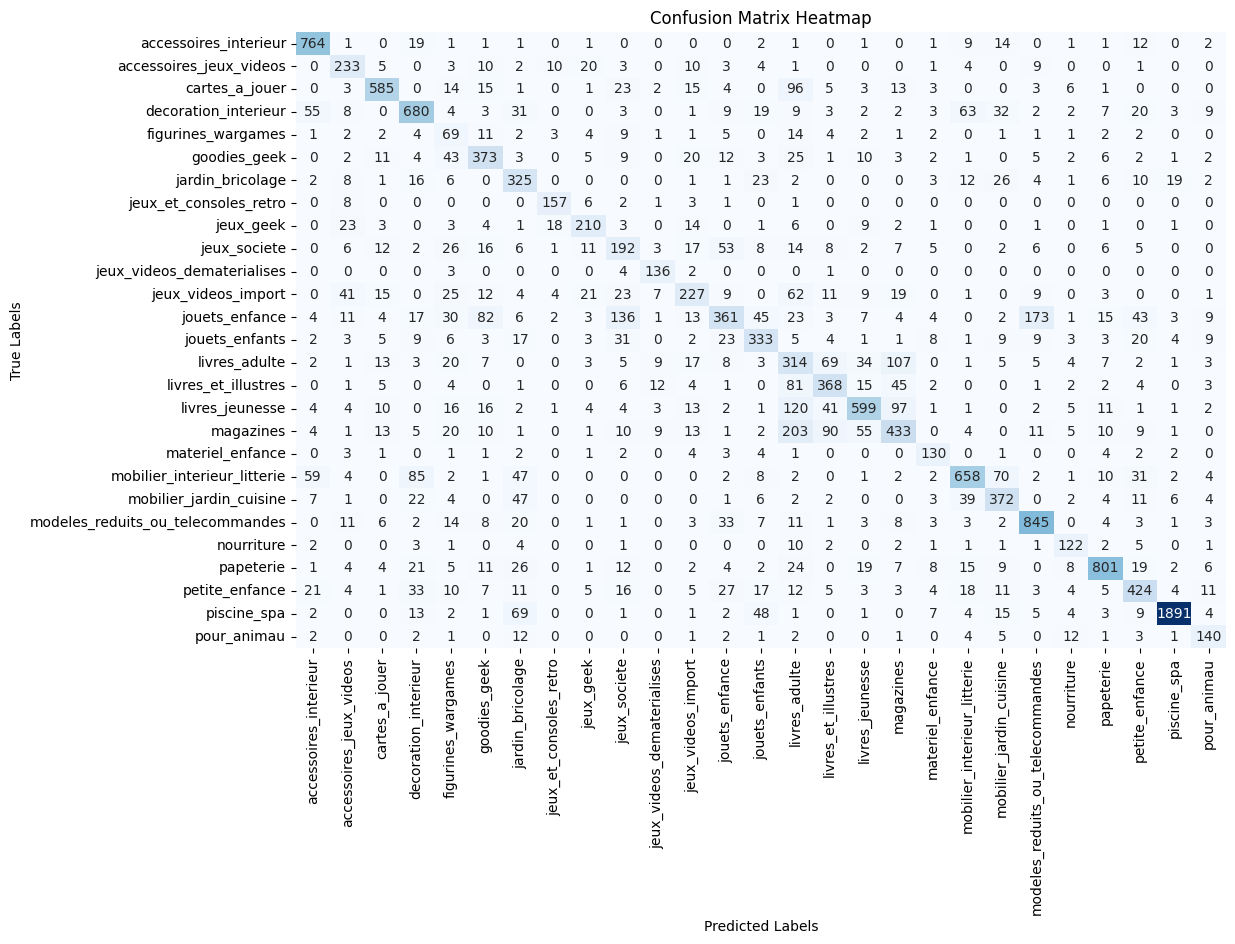

In [ ]:
y_test_original = label_encoder.inverse_transform(y_test)
svm_predictions_original = label_encoder.inverse_transform(svm_predictions)

# Get unique class names
class_names = np.unique(y_test_original)

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test_original, svm_predictions_original)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

#**Random Forest**

In [ ]:
# Train and evaluate Random Forest model with balanced class weights
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234, class_weight='balanced')
rf_model.fit(X_train, y_train)
# rf_predictions = rf_model.predict(X_test_word2vec_reshaped)
# rf_accuracy = accuracy_score(y_test, rf_predictions)
# print(f"Random Forest Accuracy with Balanced Class Weights: {rf_accuracy:.2f}")

RandomForestClassifier(class_weight='balanced', random_state=1234)

In [ ]:
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

In [ ]:
print(rf_accuracy)

0.7350447479981159


In [ ]:
y_test_original = label_encoder.inverse_transform(y_test)
rf_predictions_original = label_encoder.inverse_transform(rf_predictions)

# Generate the classification report with class names
class_report = classification_report(y_test_original, rf_predictions_original)

# Print the classification report
print(class_report)

                                  precision    recall  f1-score   support

           accessoires_interieur       0.87      0.93      0.89       832
         accessoires_jeux_videos       0.71      0.72      0.72       319
                  cartes_a_jouer       0.81      0.81      0.81       793
            decoration_interieur       0.71      0.77      0.74       970
              figurines_wargames       0.79      0.36      0.50       144
                    goodies_geek       0.71      0.72      0.71       545
                jardin_bricolage       0.68      0.65      0.66       468
          jeux_et_consoles_retro       0.93      0.82      0.87       179
                       jeux_geek       0.78      0.69      0.73       301
                    jeux_societe       0.55      0.41      0.47       408
      jeux_videos_dematerialises       0.92      0.90      0.91       146
              jeux_videos_import       0.65      0.53      0.58       503
                  jouets_enfance     

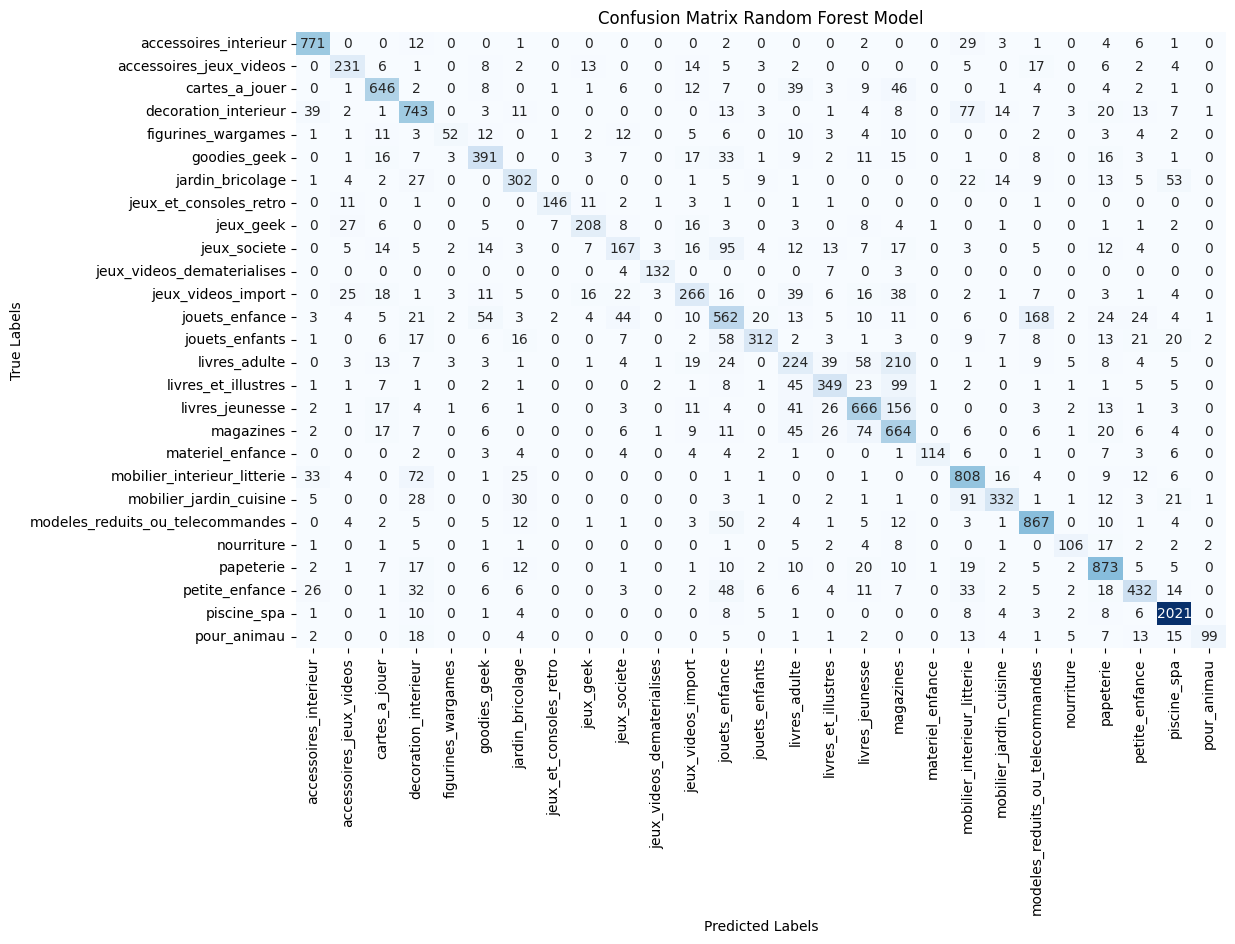

In [ ]:
y_test_original = label_encoder.inverse_transform(y_test)
svm_predictions_original = label_encoder.inverse_transform(rf_predictions)

# Get unique class names
class_names = np.unique(y_test_original)

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test_original, rf_predictions_original)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Random Forest Model')
plt.show()